In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import scanpy as sc
import scvi
import torch
import umap

from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Paired_12
from scipy import stats
from scipy.stats import pearsonr
from scvi.models.log_likelihood import log_nb_positive
from scvi.models.distributions import NegativeBinomial
from torch import Tensor

sc.set_figure_params(figsize=(4, 4))

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_model(model, title):
    """Plot model libsize and UMAP

    Parameters
    ----------
    model: scVI model
    title: str
           Plot title
    """
    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    adata = model.adata.copy()
    estimated_library_size = model.get_latent_library_size()
    actual_library_size = np.sum(X, 1)
    fig = plt.figure(figsize=(11, 5))
    ax = fig.add_subplot(121)
    ax.scatter(
        np.log10(actual_library_size),
        np.log10(estimated_library_size),
        color="black",
        s=2,
        alpha=0.5,
        label="cell",
        marker=".",
    )
    ax.set_xlabel("log_umi")
    ax.set_ylabel("scvi_libsize")
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
    ax.legend(scatterpoints=3, frameon=False)

    latent = model.get_latent_representation()
    adata.obsm["X_scVI"] = latent
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata, min_dist=0.2)
    ax = fig.add_subplot(122)
    sc.pl.umap(adata, color="named_clusters", frameon=False, ax=ax, title=title)
    fig.tight_layout()


def plot_latent_umap(model, my_cmap, ax=None, title="Latent"):
    latent = model.get_latent_representation()
    reducer = umap.UMAP(
        metric="cosine", n_neighbors=30
    )  # metric="cosine", #n_neighbors=30)
    embedding = reducer.fit_transform(latent)
    embedding_df = pd.DataFrame(embedding, columns=["0", "1"])
    all_clusters = model.adata.obs["named_clusters"].astype("category")

    if ax is None:
        fig, ax = plt.subplots()
    scatter = ax.scatter(
        embedding_df["0"].values,
        embedding_df["1"].values,
        c=all_clusters.cat.codes,
        s=3,
        cmap=my_cmap,
    )
    ax.set_title("Latent space")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.grid(False)


def plot_recons_error_genecell(model, my_cmap):
    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    X = Tensor(X)
    parameters = model.get_likelihood_parameters()
    px_rate = Tensor(parameters["mean"])
    px_r = Tensor(parameters["dispersions"])
    all_clusters = model.adata.obs["named_clusters"].astype("category")
    gene_cell_loss = (
        NegativeBinomial(mu=px_rate, theta=px_r).log_prob(X).detach().cpu().numpy()
    )

    cell_loss = gene_cell_loss.mean(1)
    gene_loss = gene_cell_loss.mean(0)
    observed_libsize_mean = X.mean(1)
    observed_gene_mean = X.mean(0)

    fig = plt.figure(figsize=(6, 3))
    all_clusters = model.adata.obs["named_clusters"].astype("category")
    ax = fig.add_subplot(121)
    # print(model.adata.var.loc[gene_loss.argsort()].head(10))
    scatter = ax.scatter(
        observed_gene_mean,
        gene_loss,
        c="black",
        s=3,
        cmap=my_cmap,
    )
    ax.set_xlabel("Gene mean")
    ax.set_ylabel("Mean reconstruction error")
    ax = fig.add_subplot(122)

    scatter = ax.scatter(
        observed_libsize_mean,
        cell_loss,
        c=all_clusters.cat.codes,
        s=3,
        cmap=my_cmap,
    )
    ax.set_xlabel("Cell mean")
    ax.set_ylabel("Mean reconstruction error")
    fig.tight_layout()


def plot_recons_error_umap(model, my_cmap, ax=None, title="Reconstruction error"):
    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    X = Tensor(X)
    parameters = model.get_likelihood_parameters()
    px_rate = Tensor(parameters["mean"])
    px_r = Tensor(parameters["dispersions"])
    all_clusters = model.adata.obs["named_clusters"].astype("category")
    gene_cell_loss = (
        NegativeBinomial(mu=px_rate, theta=px_r).log_prob(X).detach().cpu().numpy()
    )
    reducer = umap.UMAP(
        metric="cosine", n_neighbors=30
    )  # metric="cosine", #n_neighbors=30)
    embedding = reducer.fit_transform(gene_cell_loss)
    embedding_df = pd.DataFrame(embedding, columns=["0", "1"])

    if ax is None:
        fig, ax = plt.subplots()
    scatter = ax.scatter(
        embedding_df["0"].values,
        embedding_df["1"].values,
        c=all_clusters.cat.codes,
        s=3,
        cmap=my_cmap,
    )
    ax.minorticks_off()
    ax.set_title(title)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.grid(False)


def plot_latent_recons(model, my_cmap):
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(121)
    plot_recons_error_umap(model, my_cmap=my_cmap, ax=ax, title="Reconstruction error")
    ax = fig.add_subplot(122)
    plot_latent_umap(model, my_cmap=my_cmap, ax=ax, title="Reconstruction error")
    fig.tight_layout()


def plot_libsize(model, ax=None, title="Library size"):
    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    estimated_library_size = model.get_latent_library_size()
    actual_library_size = np.sum(X, 1)

    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(
        np.log10(actual_library_size),
        np.log10(estimated_library_size),
        color="black",
        s=2,
        alpha=0.5,
        label="cell",
        marker=".",
    )
    ax.set_xlabel("Observed log10(UMI)")
    ax.set_ylabel("Estimated log10(libsize)")
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
    ax.legend(scatterpoints=3, frameon=False)
    ax.set_title(title)


def plot_mean_dispersion(model, ax=None, title="Dispersion vs mean"):

    parameters = model.get_likelihood_parameters()
    px_rate = parameters["mean"]
    px_r = parameters["dispersions"]
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(px_rate, px_r, color="black", s=2, alpha=0.5)
    ax.set_xlabel("px_rate")
    ax.set_ylabel("dispersion")
    ax.set_title(title)


def plot_mean_dispersion2(
    model, ax=None, title="Dispersion vs mean (gene)", logxy=True
):

    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    parameters = model.get_likelihood_parameters()
    px_rate_obs = X.mean(0)
    px_rate_generated = parameters["mean"].mean(0)
    px_r = parameters["dispersions"][0, :]
    if ax is None:
        fig, ax = plt.subplots()
    # ax.scatter(px_rate_obs, px_r,
    #           label="observed",
    #           s=5,
    #           alpha=0.5)
    ax.scatter(
        px_rate_generated, px_r, label="generated", color="black", s=5, alpha=0.5
    )
    ax.set_xlabel("NB mean")
    ax.set_ylabel("NB dispersion")
    ax.set_title(title)
    # ax.legend(frameon=False)
    if logxy:
        ax.set_yscale("log")
        ax.set_xscale("log")


def plot_mean_mean(model, gen_counts=None, mode="cell", ax=None, title="Mean"):
    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    if gen_counts is None:
        gen_counts = model.posterior_predictive_sample()
        for i in range(99):
            gen_counts += model.posterior_predictive_sample()
        gen_counts = gen_counts / 100
    if mode == "cell":
        axis = 1
    else:
        mode = "gene"
        axis = 0
    if title == "Mean":
        title = title + " ({})".format(mode)
    gen_counts_mean = gen_counts.mean(axis)

    obs_counts_mean = X.mean(axis)

    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(
        obs_counts_mean, gen_counts_mean, s=10, color="black", alpha=0.5, label=mode
    )
    ax.set_xlabel("Observed mean")
    ax.set_ylabel("Generated mean")
    ax.set_title(title)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
    ax.legend(scatterpoints=3, frameon=False)
    ax.legend(frameon=False)


def plot_var_var(model, gen_counts=None, mode="cell", ax=None, title="Variance"):
    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    if gen_counts is None:
        gen_counts = model.posterior_predictive_sample()
        for i in range(99):
            gen_counts += model.posterior_predictive_sample()
        gen_counts = gen_counts / 100
    if mode == "cell":
        axis = 1
    else:
        mode = "gene"
        axis = 0
    if title == "Variance":
        title = title + " ({})".format(mode)
    gen_counts_var = gen_counts.var(axis)

    obs_counts_var = X.var(axis)

    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(
        obs_counts_var, gen_counts_var, s=10, alpha=0.5, color="black", label=mode
    )
    ax.set_xlabel("Observed variance")
    ax.set_ylabel("Generated variance")
    ax.set_title(title)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
    ax.legend(scatterpoints=3, frameon=False)
    ax.legend(frameon=False)


def plot_mean_var(model, gen_counts=None, mode="cell", ax=None, title="MeanVar"):
    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    if gen_counts is None:
        gen_counts = model.posterior_predictive_sample()
        for i in range(99):
            gen_counts += model.posterior_predictive_sample()
        gen_counts = gen_counts / 100
    if mode == "cell":
        axis = 1
    else:
        mode = "gene"
        axis = 0
    if title == "MeanVar":
        title = title + " ({})".format(mode)
    gen_counts_mean = gen_counts.mean(axis)
    gen_counts_var = gen_counts.var(axis)

    obs_counts_mean = X.mean(axis)
    obs_counts_var = X.var(axis)

    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(gen_counts_mean, gen_counts_var, label="Generated", s=10, alpha=0.5)
    ax.scatter(obs_counts_mean, obs_counts_var, label="Observed", s=10, alpha=0.5)
    ax.set_xlabel("Mean")
    ax.set_ylabel("Variance")
    ax.set_title(title)
    ax.legend(frameon=False)


def plot_mean_var2(model, gen_counts=None, mode="cell", ax=None, title="MeanVar"):
    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    if gen_counts is None:
        gen_counts = model.posterior_predictive_sample()
        for i in range(99):
            gen_counts += model.posterior_predictive_sample()
        gen_counts = gen_counts / 100

    if mode == "cell":
        axis = 1
    else:
        mode = "gene"
        axis = 0
    gen_counts_mean = gen_counts.mean(axis)
    gen_counts_var = gen_counts.var(axis)

    gen_ratio = gen_counts_var / gen_counts_mean
    obs_counts_mean = X.mean(axis)
    obs_counts_var = X.var(axis)

    obs_ratio = obs_counts_var / obs_counts_mean

    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(obs_ratio, gen_ratio, s=10, alpha=0.5, color="black", label=mode)
    ax.set_xlabel("Observed odf")
    ax.set_ylabel("Generated odf")
    ax.set_title(title)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
    ax.legend(scatterpoints=3, frameon=False)
    ax.legend(frameon=False)


def ppc_plots1(model):
    gen_counts = model.posterior_predictive_sample()
    for i in range(99):
        gen_counts += model.posterior_predictive_sample()
    gen_counts = gen_counts / 100
    fig = plt.figure(figsize=(6, 9))
    ax = fig.add_subplot(321)
    plot_mean_mean(
        model, gen_counts=gen_counts, mode="gene", ax=ax, title="MeanMean gene"
    )
    ax = fig.add_subplot(322)
    plot_var_var(model, gen_counts=gen_counts, mode="gene", ax=ax, title="VarVar gene")

    ax = fig.add_subplot(323)
    plot_mean_mean(
        model, gen_counts=gen_counts, mode="cell", ax=ax, title="MeanMean cell"
    )
    ax = fig.add_subplot(324)
    plot_var_var(model, gen_counts=gen_counts, mode="cell", ax=ax, title="VarVar cell")

    ax = fig.add_subplot(325)
    plot_mean_var2(
        model, gen_counts=gen_counts, mode="cell", ax=ax, title="MeanVar cell"
    )

    ax = fig.add_subplot(326)
    plot_mean_var2(
        model, gen_counts=gen_counts, mode="gene", ax=ax, title="MeanVar gene"
    )

    # return fig
    _ = fig.tight_layout()


def plot_libsize_and_dispersion(model):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(221)
    plot_libsize(model, ax=ax, title="Library size")

    ax = fig.add_subplot(222)
    plot_mean_dispersion2(model, ax=ax)
    fig.tight_layout()

    ax = fig.add_subplot(223)
    params = model.get_likelihood_parameters()
    dispersions = params["dispersions"][0, :]
    ax.hist(dispersions, color="black")
    ax.set_xlabel("NB Dispersion")
    ax.set_title("NB Disperion")
    ax.set_ylabel("Count")

    px_rate_generated = params["mean"].mean(0)
    ax = fig.add_subplot(224)

    ax.hist(px_rate_generated, color="black")
    ax.set_xlabel("NB mean")
    ax.set_ylabel("Count")
    ax.set_title("NB mean")

    fig.tight_layout()


def plot_detection_rate(model):
    X = model.adata.layers["counts"]
    if not isinstance(model.adata.layers["counts"], np.ndarray):
        X = X.toarray()

    observed_detection_rate = np.sum(X > 0, 0) / X.shape[0]

    gen_counts = model.posterior_predictive_sample()
    generated_detection_rate = np.sum(gen_counts > 0, 0) / X.shape[0]
    for i in range(99):
        gen_counts = model.posterior_predictive_sample()
        generated_detection_rate += np.sum(gen_counts > 0, 0) / X.shape[0]
    generated_detection_rate /= 100
    gen_counts /= 100

    generated_gene_mean = gen_counts.mean(0)
    observed_gene_mean = gen_counts.mean(0)
    # if ax is None:
    #    fig, ax = plt.subplots()
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(121)
    ax.scatter(
        observed_detection_rate,
        generated_detection_rate,
        s=10,
        color="black",
        alpha=0.5,
        label="Gene",
    )
    ax.set_xlabel("Observed detection rate")
    ax.set_ylabel("Generated detection rate")
    # ax.set_title("Observed vs generated detection rate")
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
    ax.set_title("Gen vs obs det. rate")
    ax.legend(scatterpoints=3, frameon=False)

    ax = fig.add_subplot(122)
    ax.scatter(
        observed_gene_mean, observed_detection_rate, s=10, alpha=0.5, label="Observed"
    )
    ax.scatter(
        generated_gene_mean,
        generated_detection_rate,
        s=10,
        alpha=0.5,
        label="Generated",
    )
    ax.set_xlabel("Gene mean")
    ax.set_ylabel("Detection rate")
    ax.legend(frameon=False)
    ax.set_title("Detection rate vs mean")
    fig.tight_layout()
    
    
def gen_mean_var_plot(X, gen_counts, mode="gene"):
    if mode == "gene":
        axis = 0
    else:
        axis = 1
    gen_counts_mean = gen_counts.mean(axis)
    gen_counts_var = gen_counts.var(axis)

    gen_ratio = gen_counts_var / gen_counts_mean
    obs_counts_mean = X.mean(axis)
    obs_counts_var = X.var(axis)

    obs_ratio = obs_counts_var / obs_counts_mean

    fig = plt.figure(figsize=(6, 6))

    ax = fig.add_subplot(221)
    ax.scatter(
        obs_counts_mean, gen_counts_mean, s=10, alpha=0.5, color="black", label=mode
    )
    ax.set_xlabel("Observed mean")
    ax.set_ylabel("Generated mean")
    ax.set_title("Mean (gene)")
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
    ax.legend(scatterpoints=3, frameon=False)

    ax = fig.add_subplot(222)
    ax.scatter(
        obs_counts_var, gen_counts_var, s=10, alpha=0.5, color="black", label=mode
    )
    ax.set_xlabel("Observed var")
    ax.set_ylabel("Generated var")
    ax.set_title("Variance (gene)")
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
    ax.legend(scatterpoints=3, frameon=False)

    ax = fig.add_subplot(223)
    ax.scatter(obs_ratio, gen_ratio, s=10, alpha=0.5, color="black", label=mode)
    ax.set_xlabel("Observed odf")
    ax.set_ylabel("Generated odf")
    ax.set_title("odf")
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
    ax.legend(scatterpoints=3, frameon=False)
    ax.legend(frameon=False)

    fig.tight_layout()
    
    
def plot_umap(model):
    adata = model.adata.copy()
    latent = model.get_latent_representation()
    adata.obsm["X_scVI"] = latent
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata, min_dist=0.2)
    ax = fig.add_subplot(122)
    sc.pl.umap(adata, color="named_clusters", frameon=False, title="")

In [3]:
pbmc3k_colors = (
    sns.color_palette("muted").as_hex() + sns.color_palette("Set3").as_hex()[4:6]
)
pbmc3k_cmap = ListedColormap(pbmc3k_colors)

In [4]:
pbmc3k_adata = sc.read_10x_mtx("../data/pbmc3k/filtered_gene_bc_matrices/hg19/")
metadata = pd.read_csv(
    "../data/pbmc3k/processed_for_scvi/SCT_corrected_counts_10X/metadata.tsv",
    sep="\t",
    index_col=0,
)
pbmc3k_adata.obs["named_clusters"] = metadata["celltype"]
pbmc3k_adata.layers["counts"] = pbmc3k_adata.X.copy()  # preserve counts
sc.pp.filter_genes(pbmc3k_adata, min_counts=1)
sc.pp.filter_cells(pbmc3k_adata, min_counts=1)
sc.pp.normalize_total(pbmc3k_adata, target_sum=1e4)
sc.pp.log1p(pbmc3k_adata)

pbmc3k_adata.raw = pbmc3k_adata  # freeze the state in `.raw`
sc.pp.highly_variable_genes(
    pbmc3k_adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

scvi.data.setup_anndata(pbmc3k_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2700 cells, 3000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/gpfs/commons/home/schoudhary/software/anaconda3/envs/scvi-dev/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [5]:
pbmc3k_adata.shape

(2700, 3000)

In [6]:
pbmc33k_adata = sc.read_10x_mtx("../data/pbmc33k/filtered_gene_bc_matrices/hg19/")
metadata = pd.read_csv(
    "../data/pbmc33k/pbmc33k_azimuth_pred.tsv", sep="\t", index_col=0
)

cells_to_keep = metadata[metadata["predicted.id"] == "CD8 Naive"].index


pbmc33k_adata.obs["named_clusters"] = metadata["predicted.id"]
pbmc33k_adata_sampled = pbmc33k_adata[cells_to_keep, pbmc3k_adata.var.index].copy()
pbmc33k_adata_sampled.layers[
    "counts"
] = pbmc33k_adata_sampled.X.copy()  # preserve counts
scvi.data.setup_anndata(pbmc33k_adata_sampled, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1327 cells, 3000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [7]:
pbmc3k_model = scvi.model.SCVI(
    pbmc3k_adata,
    n_hidden=128,
    n_latent=10,
    n_layers=1,
    dropout_rate=0.1,
    dispersion="gene",
    gene_likelihood="nb",
    latent_distribution="normal",
    use_cuda=True,
    use_observed_lib_size=False,
)
pbmc3k_model.train()
pbmc3k_model.save("pbmc3k_model_scvi_genedisp_latentlibsize/", overwrite=True)


INFO     Training for 400 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 400/400 [02:05<00:00,  3.19it/s]
INFO     Training time:  125 s. / 400 epochs                                                 


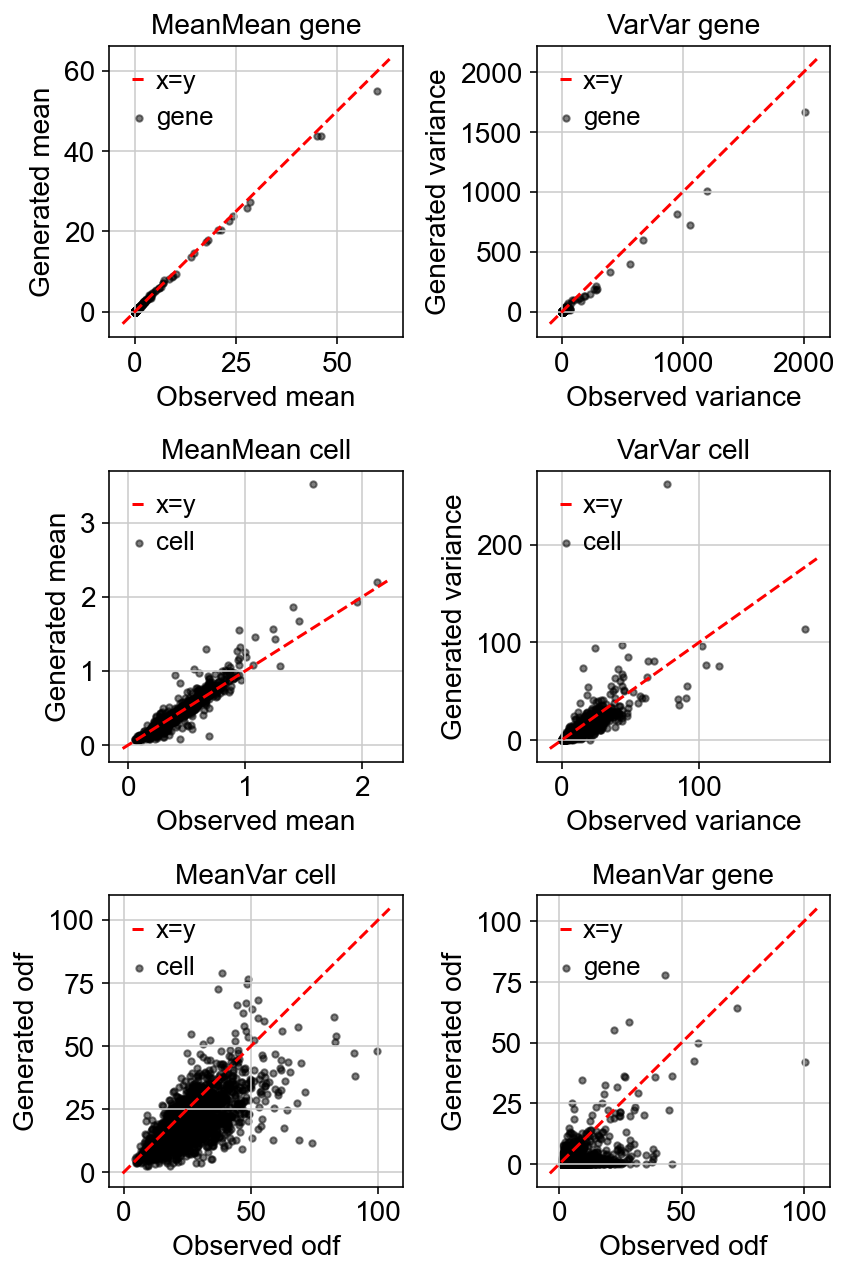

In [8]:
ppc_plots1(pbmc3k_model)

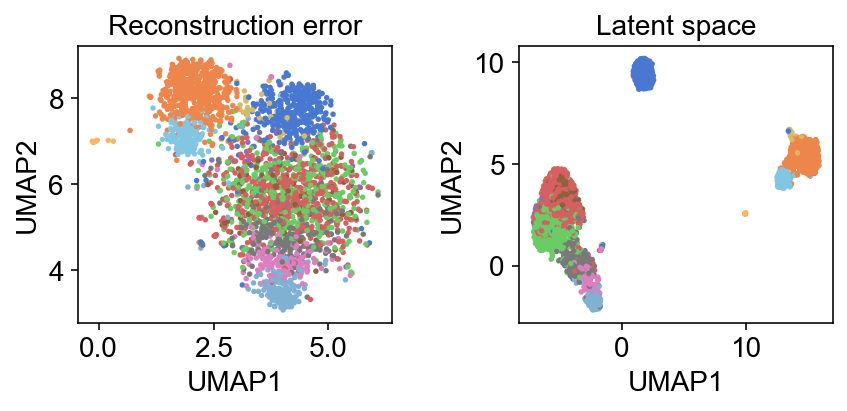

In [9]:
plot_latent_recons(pbmc3k_model, pbmc3k_cmap)

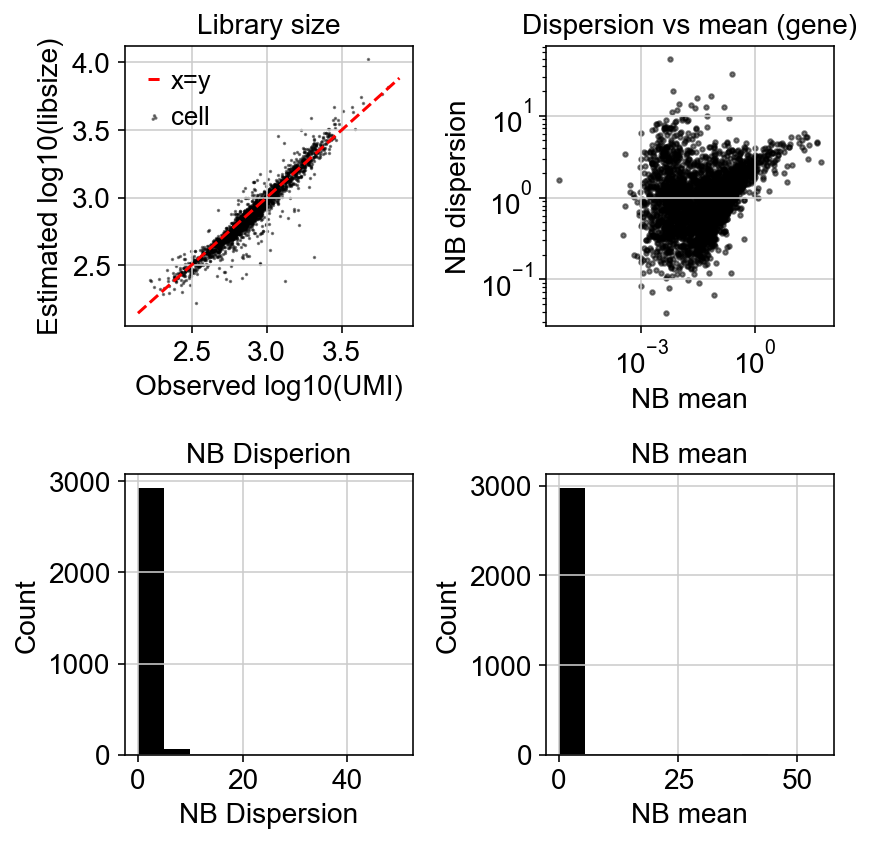

In [10]:
plot_libsize_and_dispersion(pbmc3k_model)

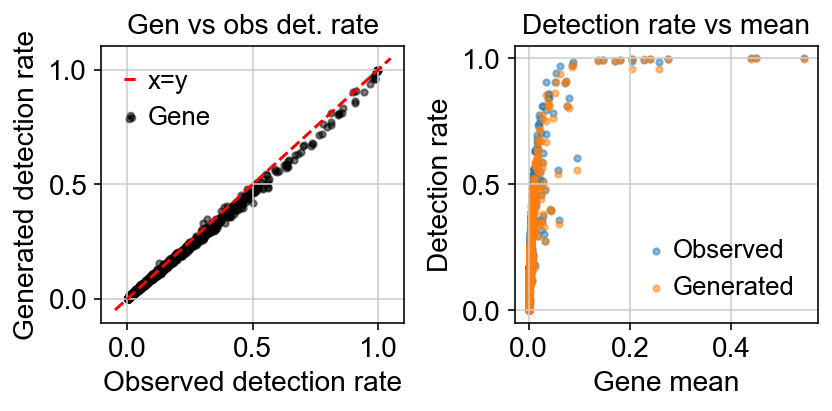

In [11]:
plot_detection_rate(pbmc3k_model)

... storing 'named_clusters' as categorical


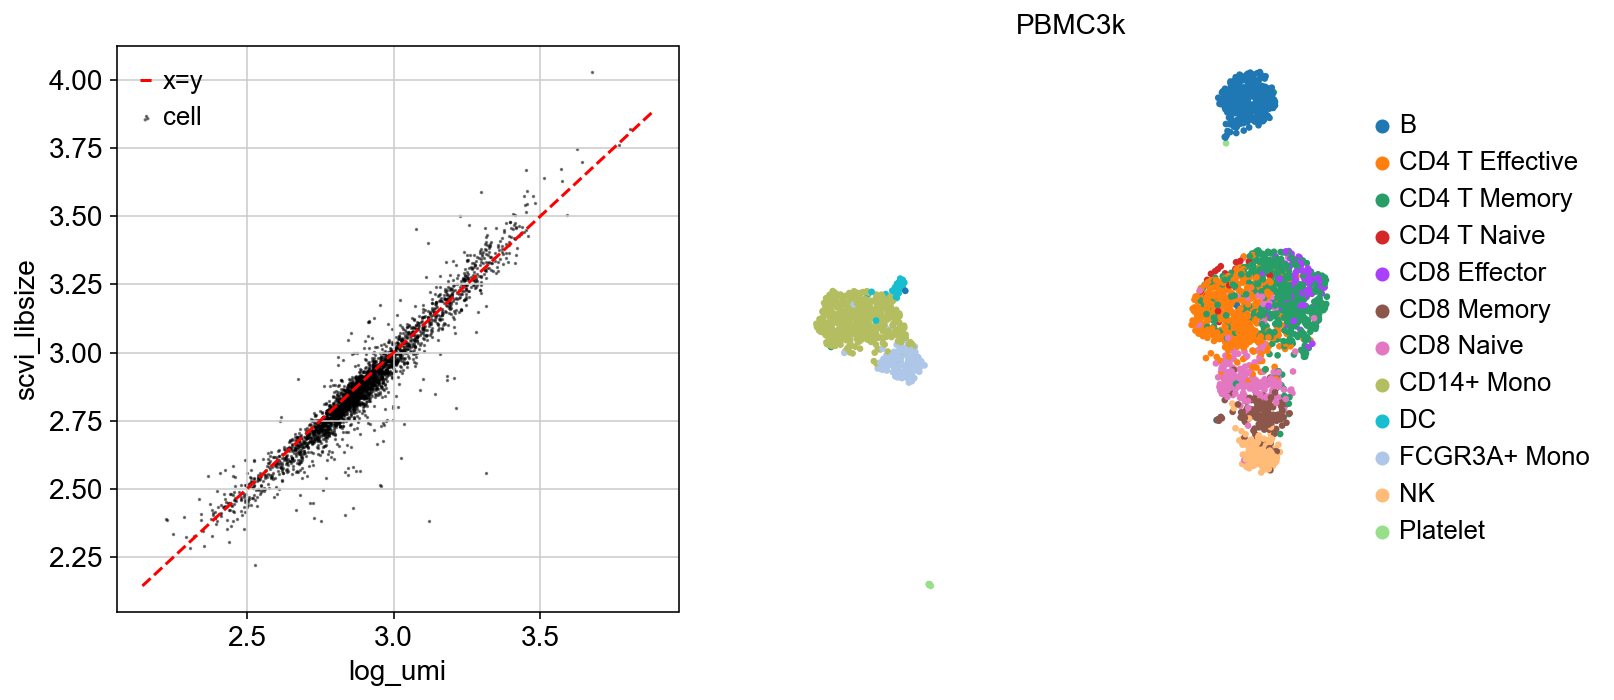

In [12]:
plot_model(pbmc3k_model, "PBMC3k")

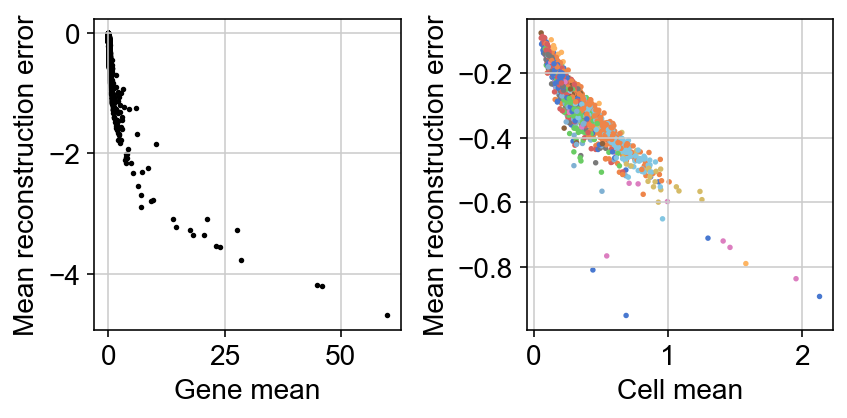

In [13]:
plot_recons_error_genecell(pbmc3k_model, pbmc3k_cmap)

In [15]:
pbmc3k_normalized_expression = pbmc3k_model.get_normalized_expression(
    n_samples=100, return_mean=True
)
metadata = pbmc3k_model.adata.obs
pbmc3k_normalized_expression_cd8naive = pbmc3k_normalized_expression.loc[
    metadata.loc[metadata["named_clusters"] == "CD8 Naive"].index.tolist()
]
pbmc3k_normalized_expression_sum = pd.DataFrame(
    pbmc3k_normalized_expression.sum(0), columns=["total_norm_exp"]
)
pbmc3k_normalized_expression_sum = pbmc3k_normalized_expression_sum.sort_values(
    by="total_norm_exp"
)

In [16]:
pbmc3k_normalized_expression_sum["cuts"] = pd.qcut(
    pbmc3k_normalized_expression_sum.total_norm_exp,
    q=[0.1, 0.20, 0.40, 0.60, 0.80, 0.90, 0.95, 1],
    labels=["Q20", "Q40", "Q60", "Q80", "Q90", "Q95", "Q100"],
)
pbmc3k_normalized_expression_sum

,total_norm_exp,cuts
MICALCL,0.000018,NaN
KNDC1,0.000725,NaN
CEP55,0.000777,NaN
SPC25,0.000782,NaN
NCAPG,0.000938,NaN
...,...,...
RPS2,80.668694,Q100
RPL13,96.838272,Q100
TMSB4X,137.072113,Q100
B2M,146.207077,Q100


In [17]:
pbmc3k_original_libsize = pd.DataFrame(
    pbmc3k_model.adata.layers["counts"].sum(1), columns=["libsize"]
)
pbmc3k_original_libsize.index = pbmc3k_model.adata.obs.index
pbmc3k_original_libsize_cd8naive = pbmc3k_original_libsize.loc[
    pbmc3k_normalized_expression_cd8naive.index
]

Text(0, 0.5, 'Frequency')

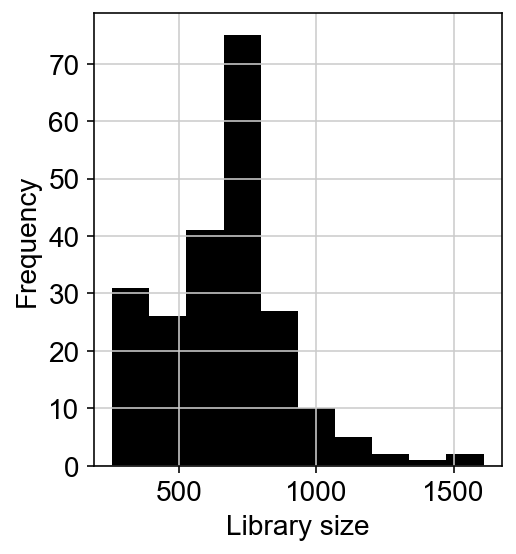

In [18]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.hist(pbmc3k_original_libsize_cd8naive.libsize, color="black")
ax.set_xlabel("Library size")
ax.set_ylabel("Frequency")

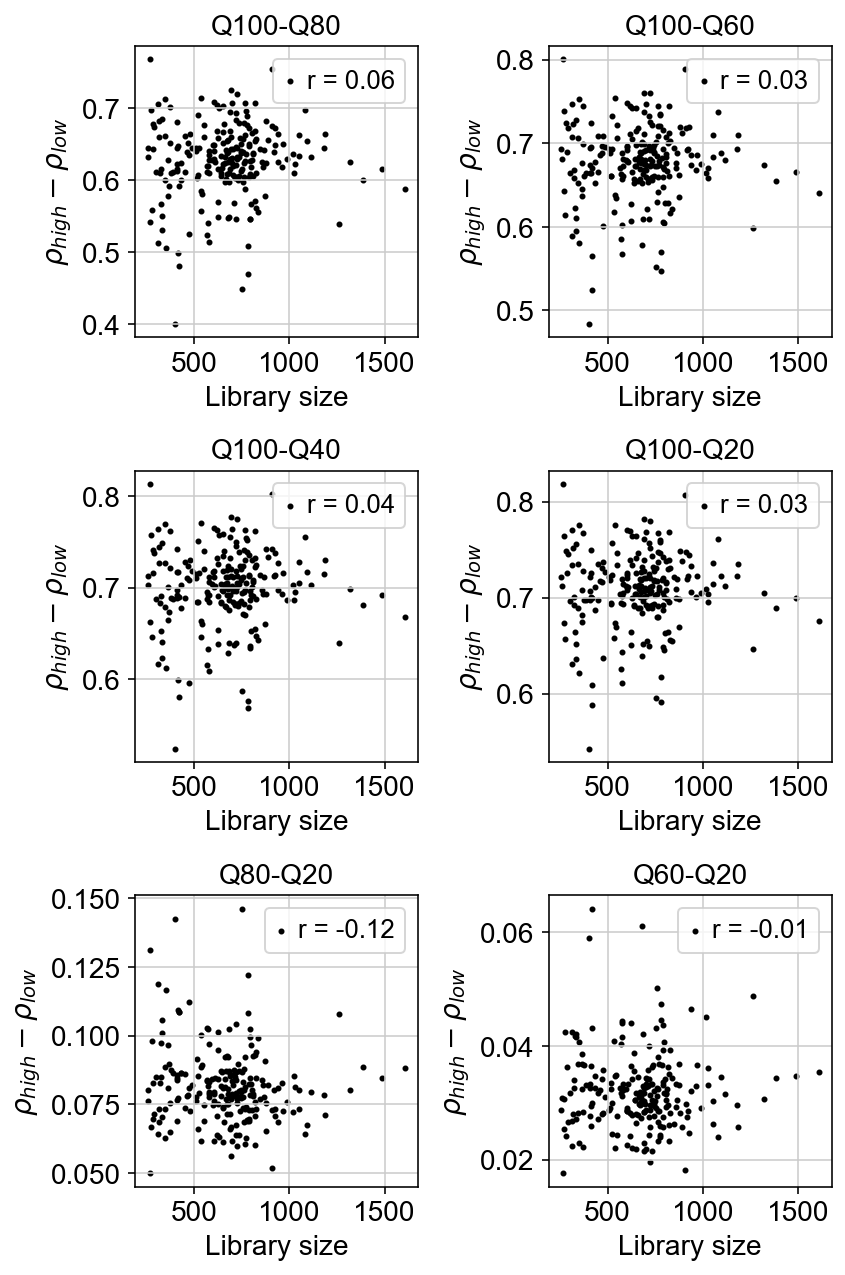

In [19]:
# pbmc3k_normalized_expression_sum
# high_exp_genes = pbmc3k_normalized_expression_sum.iloc[2500:2600].index.tolist()# .tail(0).index.tolist()
# low_exp_genes = pbmc3k_normalized_expression_sum.head(100).index.tolist()
# low_exp_genes = pbmc3k_normalized_expression_sum.iloc[2400:2500].index.tolist()
# head(100).index.tolist()


def plot_high_vs_low_diff(Q1, Q2, ax):
    high_exp_genes = pbmc3k_normalized_expression_sum.loc[
        pbmc3k_normalized_expression_sum.cuts == Q1
    ].index.tolist()
    low_exp_genes = pbmc3k_normalized_expression_sum.loc[
        pbmc3k_normalized_expression_sum.cuts == Q2
    ].index.tolist()

    high_vs_low_exp_diff = pd.DataFrame(
        pbmc3k_normalized_expression_cd8naive[high_exp_genes]
        .sum(1)
        .subtract(pbmc3k_normalized_expression_cd8naive[low_exp_genes].sum(1)),
        columns=["high_vs_low_diff"],
    )
    high_vs_low_exp_diff = high_vs_low_exp_diff.join(
        pbmc3k_original_libsize_cd8naive, how="inner"
    )

    corr = pearsonr(high_vs_low_exp_diff.libsize, high_vs_low_exp_diff.high_vs_low_diff)
    ax.scatter(
        high_vs_low_exp_diff.libsize,
        high_vs_low_exp_diff.high_vs_low_diff,
        s=4,
        color="black",
        label="r = {}".format(np.round(corr[0], 2)),
    )
    ax.legend()
    ax.set_xlabel("Library size")
    ax.set_ylabel(r"$\rho_{high} - \rho_{low}$")
    ax.set_title("{}-{}".format(Q1, Q2))


fig = plt.figure(figsize=(6, 9))
ax = fig.add_subplot(321)
plot_high_vs_low_diff("Q100", "Q80", ax)
ax = fig.add_subplot(322)
plot_high_vs_low_diff("Q100", "Q60", ax)
ax = fig.add_subplot(323)
plot_high_vs_low_diff("Q100", "Q40", ax)
ax = fig.add_subplot(324)
plot_high_vs_low_diff("Q100", "Q20", ax)
ax = fig.add_subplot(325)
plot_high_vs_low_diff("Q80", "Q20", ax)
ax = fig.add_subplot(326)
plot_high_vs_low_diff("Q60", "Q20", ax)
fig.tight_layout()

/gpfs/commons/home/schoudhary/software/anaconda3/envs/scvi-dev/lib/python3.7/site-packages/scvi/models/distributions.py:135: UserWarning: The value argument must be within the support of the distribution
  UserWarning,
/gpfs/commons/home/schoudhary/software/anaconda3/envs/scvi-dev/lib/python3.7/site-packages/scvi/models/distributions.py:135: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


-1.6123982450169612
-1.6120894953927714


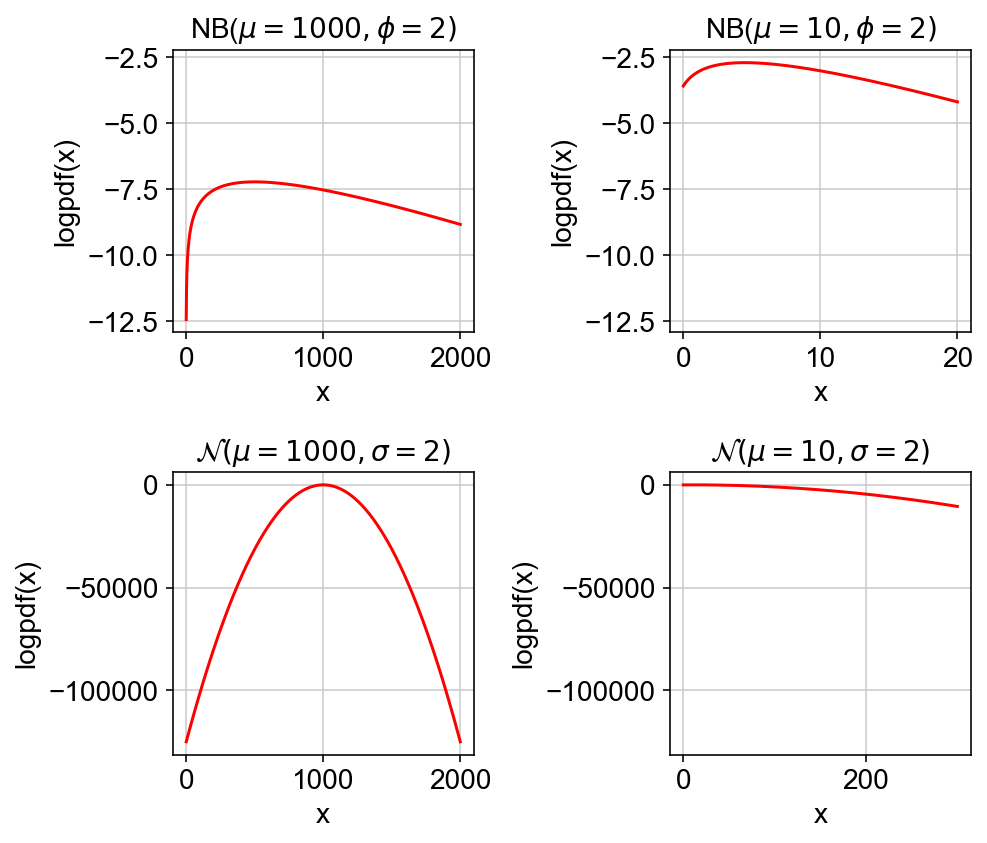

In [20]:
fig = plt.figure(figsize=(7, 6))
ax1 = fig.add_subplot(221)
x = np.linspace(0, 2000, 2000)
x = x.astype(float)
ax1.plot(x, NegativeBinomial(mu=1000, theta=2).log_prob(torch.tensor(x)), color="red")
ax1.set_xlabel("x")
ax1.set_ylabel("logpdf(x)")
ax1.set_title(r"NB($\mu=1000,\phi=2)$")
ax2 = fig.add_subplot(222, sharey=ax1)
x = np.linspace(0, 20, 20000)
x = x.astype(float)
ax2.plot(x, NegativeBinomial(mu=10, theta=2).log_prob(torch.tensor(x)), color="red")
ax2.set_xlabel("x")
ax2.set_ylabel("logpdf(x)")
ax2.set_title(r"NB($\mu=10,\phi=2)$")


r = stats.norm(loc=1000, scale=2)
x = np.linspace(0, 2000, 20000)

#fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_subplot(223)
ax1.plot(x, r.logpdf(x), color="red")
print(r.logpdf(x).max())
ax1.set_xlabel("x")
ax1.set_ylabel("logpdf(x)")
ax1.set_title(r"$\mathcal{N}(\mu=1000,\sigma=2)$")

ax2 = fig.add_subplot(224, sharey=ax1)
r = stats.norm(loc=10, scale=2)
x = np.linspace(0, 300, 20000)
print(r.logpdf(x).max())
ax2.set_xlabel("x")
ax2.set_ylabel("logpdf(x)")
ax2.set_title(r"$\mathcal{N}(\mu=10,\sigma=2)$")

ax2.plot(x, r.logpdf(x), color="red")
fig.tight_layout()

/gpfs/commons/home/schoudhary/software/anaconda3/envs/scvi-dev/lib/python3.7/site-packages/scvi/models/distributions.py:135: UserWarning: The value argument must be within the support of the distribution
  UserWarning,
/gpfs/commons/home/schoudhary/software/anaconda3/envs/scvi-dev/lib/python3.7/site-packages/scvi/models/distributions.py:135: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


-1.6120857140771492
-1.6120857137677431


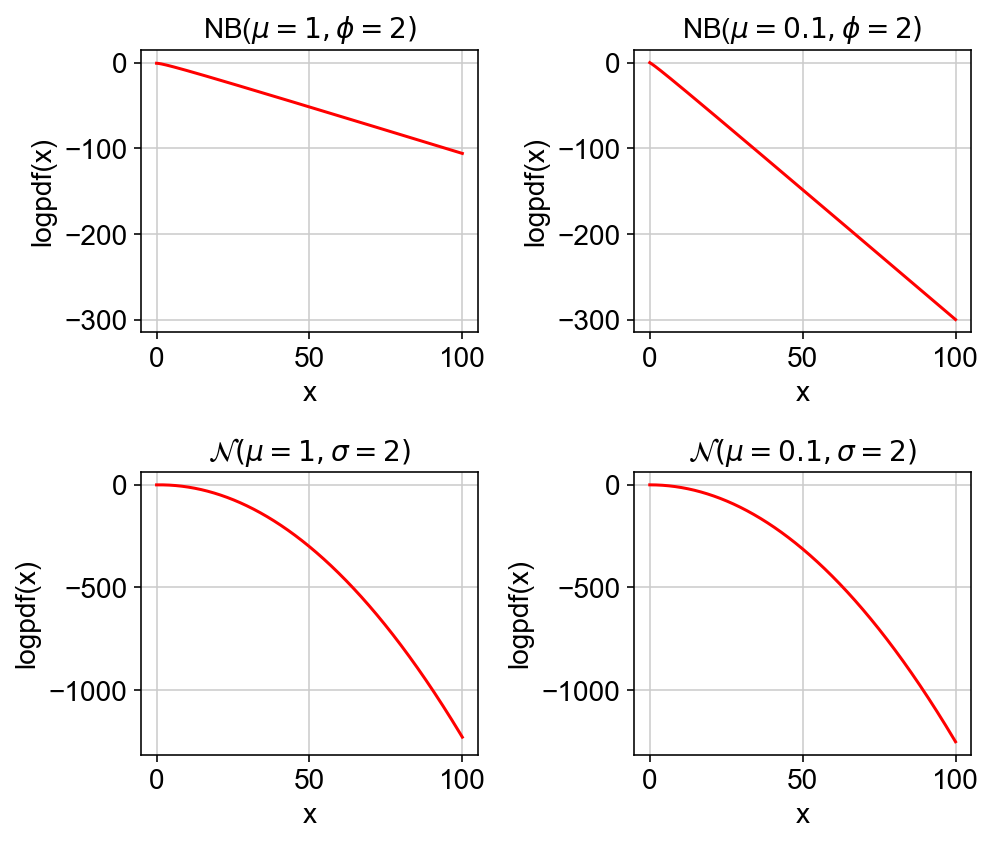

In [21]:
fig = plt.figure(figsize=(7, 6))
ax1 = fig.add_subplot(221)
x = np.linspace(0, 100, 20000)
x = x.astype(float)
ax1.plot(x, NegativeBinomial(mu=1, theta=2).log_prob(torch.tensor(x)), color="red")
ax1.set_xlabel("x")
ax1.set_ylabel("logpdf(x)")
ax1.set_title(r"NB($\mu=1,\phi=2)$")
ax2 = fig.add_subplot(222, sharey=ax1)
x = np.linspace(0, 100, 20000)
x = x.astype(float)
ax2.plot(x, NegativeBinomial(mu=0.1, theta=2).log_prob(torch.tensor(x)), color="red")
ax2.set_xlabel("x")
ax2.set_ylabel("logpdf(x)")
ax2.set_title(r"NB($\mu=0.1,\phi=2)$")


r = stats.norm(loc=1, scale=2)
x = np.linspace(0, 100, 20000)

#fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_subplot(223)
ax1.plot(x, r.logpdf(x), color="red")
print(r.logpdf(x).max())
ax1.set_xlabel("x")
ax1.set_ylabel("logpdf(x)")
ax1.set_title(r"$\mathcal{N}(\mu=1,\sigma=2)$")

ax2 = fig.add_subplot(224, sharey=ax1)
r = stats.norm(loc=0.1, scale=2)
x = np.linspace(0, 100, 20000)
print(r.logpdf(x).max())
ax2.set_xlabel("x")
ax2.set_ylabel("logpdf(x)")
ax2.set_title(r"$\mathcal{N}(\mu=0.1,\sigma=2)$")

ax2.plot(x, r.logpdf(x), color="red")
fig.tight_layout()